In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
Data = pd.read_csv("Realty.csv")
X = Data[['f1','f2']]
y = Data['target'] 

In [3]:
Data.head()

,f1,f2,target
0,0.943625,-0.679783,1
1,-0.868018,-0.253922,-1
2,-1.767471,-0.999924,-1
3,0.572276,0.394579,1
4,-1.436026,-1.307645,-1


Метод опорных векторов (SVM) в простейшем виде без библиотек машинного обучения. Мы используем линейное SVM с линейным ядром и стохастическим градиентным спуском, реализуя hinge loss (функцию потерь с зазором).

Функция для вычисления функции потерь SVM (hinge-loss):

$$L = \frac12 ||w||^2 + \frac1n\cdot C\cdot \sum\limits_{i=1}^n max(0, 1 - y_i\cdot (w_0 + (w,x_i)))$$

Можно вычислить второе слагаемое в векторном виде: $\frac1n\cdot C\cdot max(0, 1 - y \cdot (Xw + w_0))$

In [4]:
def compute_cost(X, y, w, C):
    '''
    X - матрица объект-признак (c добавленным столбцом единиц)
    y - вектор целевой переменной (значения +1 или -1)
    w - вектор весов (включая смещение b)
    C - параметр регуляризации
    '''
    n = X.shape[0]
    distances = 1 - y * np.dot(X, w)
    hinge_loss = np.maximum(0, distances)
    cost = 0.5 * np.dot(w[1:], w[1:]) + C * np.mean(hinge_loss)  # не регуляризуем bias (w[0])
    return cost

Функция для вычисления градиента функции потерь на одном объекте по формуле:

$\nabla Q_i = w$, если $max(0, 1-y_i\cdot(w,x_i))=0$

и 

$\nabla Q_i = w - Cx_iy_i$, иначе.



Для веса $w_0$ формулы следующие:

$\frac{\partial Q_i}{\partial w_0} = 0$, если $max(0, 1-y_i\cdot(w,x_i))=0$

и 

$\frac{\partial Q_i}{\partial w_0} = - Cx_iy_i$, иначе.

Функция вычисления вектора - градиента.

In [5]:
def calculate_cost_gradient(x_input, y_input, w, C):
    '''
    x_input - вектор признаков (включая 1 на первой позиции — смещение)
    y_input - целевая переменная (+1 или -1)
    w - веса модели
    C - параметр регуляризации
    '''
    if y_input * np.dot(x_input, w) < 1:
        dw = np.zeros_like(w)
        dw[1:] = w[1:] - C * y_input * x_input[1:]
        dw[0] = -C * y_input * x_input[0]  # смещение обрабатываем отдельно
    else:
        dw = np.zeros_like(w)
        dw[1:] = w[1:]  # только регуляризация
    return dw



Стохастический градиентный спуск

In [6]:
def stochastic_gradient_descent(X, y, params, learning_rate, iterations, C):
    n = X.shape[0]
    cost_track = np.zeros((iterations, 1))
    
    for i in range(iterations):
        idx = random.randint(0, n - 1)
        x_i = X[idx]
        y_i = y[idx]
        grad = calculate_cost_gradient(x_i, y_i, params, C)
        params = params - learning_rate * grad
        cost_track[i] = compute_cost(X, y, params, C)
    
    return cost_track, params

Функция получения предсказания

In [7]:
def predict(X, params):
    '''
    X — матрица признаков без единичного столбца
    params — вектор параметров (bias + weights)
    '''
    X_augmented = np.hstack([np.ones((X.shape[0], 1)), X])  # добавим единичку
    return np.sign(np.dot(X_augmented, params))

Подготовка данных

In [8]:
# Преобразуем y в формат {-1, +1}
y = y.values
y = np.where(y == -1, -1, 1)

# Добавим единичный столбец к X
X_aug = np.hstack([np.ones((X.shape[0], 1)), X.values])

# Инициализация весов
params = np.random.randn(X_aug.shape[1])

# Параметры обучения
learning_rate = 0.01
iterations = 3000
C = 1.0

# Обучение
cost_track, trained_params = stochastic_gradient_descent(X_aug, y, params, learning_rate, iterations, C)

# Предсказание
y_pred = predict(X.values, trained_params)

Выведем значения весов

In [9]:
print("b =", trained_params[0])
print("w1 =", trained_params[1])
print("w2 =", trained_params[2])
print("w1/w2 =", trained_params[1] / trained_params[2])

b = 0.09337545572327816
w1 = 0.7112237080401854
w2 = 0.05548502402628389
w1/w2 = 12.818300442715328


График функции стоимости (loss)

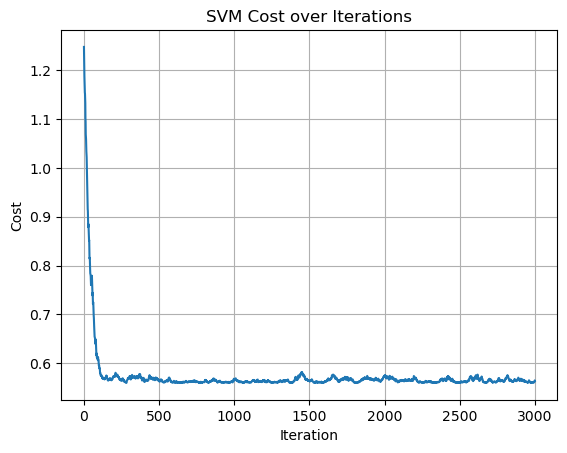

In [10]:
plt.plot(cost_track)
plt.title("SVM Cost over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

Визуализация данных и разделяющей гиперплоскости

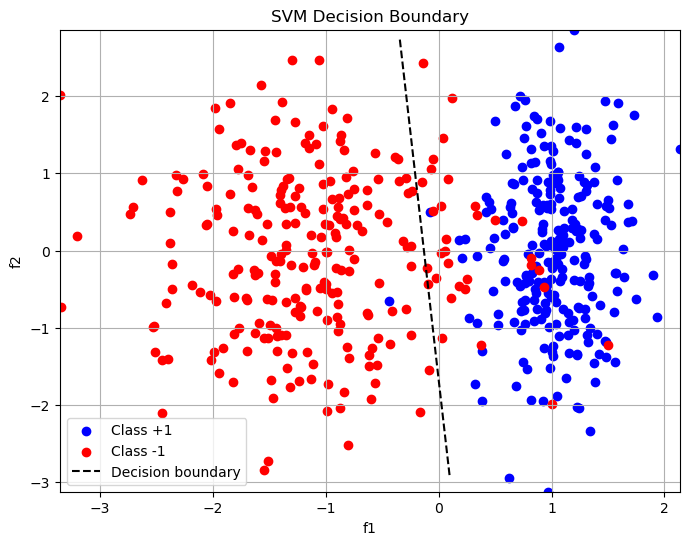

In [11]:
# Построим границу решения
def plot_decision_boundary(X, y, params):
    plt.figure(figsize=(8, 6))
    
    # Разделим по классам
    pos = y == 1
    neg = y == -1
    plt.scatter(X[pos, 0], X[pos, 1], color='blue', label='Class +1')
    plt.scatter(X[neg, 0], X[neg, 1], color='red', label='Class -1')

    # Получим веса и bias
    b = params[0]
    w1, w2 = params[1], params[2]
    
   # Диапазон по X
    x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 300)
    
    # Вычисление Y, с защитой от деления на 0
    if abs(w2) < 1e-6:
        # Почти вертикальная граница
        x0 = -b / w1
        plt.axvline(x=x0, linestyle='--', color='k', label='Decision boundary')
    else:
        y_vals = -(w1 * x_vals + b) / w2

        # Ограничим значения по Y
        min_y, max_y = np.min(X[:, 1]), np.max(X[:, 1])
        y_vals_clipped = np.clip(y_vals, min_y, max_y)

        # Убираем участки, где обрезка изменила значение
        valid_mask = (y_vals == y_vals_clipped)
        plt.plot(x_vals[valid_mask], y_vals_clipped[valid_mask], 'k--', label='Decision boundary')

    # Границы осей
    plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))    

    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.title('SVM Decision Boundary')
    plt.legend()
    plt.grid(True)
    plt.show()

# Вызов визуализации
plot_decision_boundary(X.values, y, trained_params)

Добавим к графику **две линии поддержки (margins)**, соответствующие уравнениям:

    w1x+w2y+b=+1w1​x+w2​y+b=+1

    w1x+w2y+b=−1w1​x+w2​y+b=−1

Эти линии проходят через **опорные векторы**, и определяют ширину зазора (margin) между классами.

In [12]:
def plot_decision_boundary_with_margin(X, y, params):
    plt.figure(figsize=(8, 6))

    # Классы
    pos = y == 1
    neg = y == -1
    plt.scatter(X[pos, 0], X[pos, 1], color='blue', label='Class +1')
    plt.scatter(X[neg, 0], X[neg, 1], color='red', label='Class -1')

    # Параметры
    b = params[0]
    w1, w2 = params[1], params[2]

    # Диапазоны
    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
    x_vals = np.linspace(x_min, x_max, 300)

    if abs(w2) < 1e-6:
        # Вертикальная граница
        x0 = -b / w1
        plt.axvline(x=x0, linestyle='--', color='k', label='Decision boundary')
        plt.axvline(x=x0 - 1 / w1, linestyle='-.', color='g', label='Margin -1')
        plt.axvline(x=x0 + 1 / w1, linestyle='-.', color='g', label='Margin +1')
    else:
        # Функция линии с ограничением по Y
        def safe_line(offset):
            y_vals = -(w1 * x_vals + b - offset) / w2
            y_vals_clipped = np.clip(y_vals, y_min, y_max)
            valid_mask = (y_vals == y_vals_clipped)
            return x_vals[valid_mask], y_vals_clipped[valid_mask]

        x0, y0 = safe_line(0)
        x1, y1 = safe_line(1)
        x_1, y_1 = safe_line(-1)

        plt.plot(x0, y0, 'k--', label='Decision boundary')
        plt.plot(x1, y1, 'g-.', label='Margin +1')
        plt.plot(x_1, y_1, 'g-.', label='Margin -1')

    # Ограничения осей
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.title('SVM Decision Boundary with Margins')
    plt.legend()
    plt.grid(True)
    plt.show()


**Визуализируем**

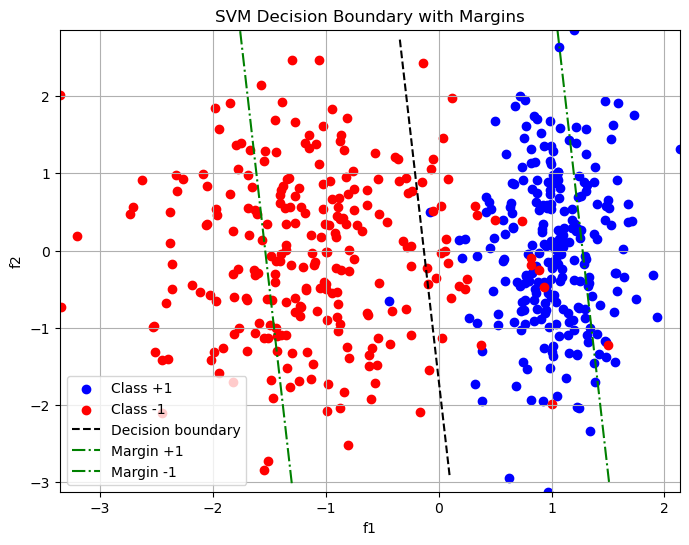

In [13]:
# Вызов
plot_decision_boundary_with_margin(X.values, y, trained_params)

Продолжим с выделением **опорных векторов и ошибочных классификаций**. Это поможет увидеть, какие точки "держат" границу, и где алгоритм ошибается.

In [ ]:
def plot_support_vectors_and_misclassified(X, y, params, threshold=1e-2):
    plt.figure(figsize=(8, 6))

    b = params[0]
    w = params[1:]
    w1, w2 = w[0], w[1]

    # Добавим смещение к X
    X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
    decision_values = X_aug @ params
    margins = y * decision_values

    # Метки
    misclassified = margins < 0
    support_vector_margin = np.abs(margins - 1) < threshold

    # Диапазоны
    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
    x_vals = np.linspace(x_min, x_max, 300)

    # Точки классов
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class +1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1')

    # Опорные векторы
    plt.scatter(X[support_vector_margin, 0], X[support_vector_margin, 1],
                facecolors='none', edgecolors='black', linewidths=2, s=100, label='Support Vectors')

    # Ошибки
    plt.scatter(X[misclassified, 0], X[misclassified, 1],
                color='yellow', edgecolors='black', marker='x', s=100, label='Misclassified')

    # Отрисовка границ
    if abs(w2) < 1e-6:
        x0 = -b / w1
        plt.axvline(x=x0, linestyle='--', color='k', label='Decision boundary')
        plt.axvline(x=x0 - 1 / w1, linestyle='-.', color='g', label='Margin -1')
        plt.axvline(x=x0 + 1 / w1, linestyle='-.', color='g', label='Margin +1')
    else:
        def safe_line(offset):
            y_vals = -(w1 * x_vals + b - offset) / w2
            y_vals_clipped = np.clip(y_vals, y_min, y_max)
            valid_mask = (y_vals == y_vals_clipped)
            return x_vals[valid_mask], y_vals_clipped[valid_mask]

        x0, y0 = safe_line(0)
        x1, y1 = safe_line(1)
        x_1, y_1 = safe_line(-1)

        plt.plot(x0, y0, 'k--', label='Decision boundary')
        plt.plot(x1, y1, 'g-.', label='Margin +1')
        plt.plot(x_1, y_1, 'g-.', label='Margin -1')

    # Ограничения и оформление
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("SVM with Support Vectors and Misclassified Points")
    plt.legend()
    plt.grid(True)
    plt.show()


Итог:

    🔵 Синие и 🔴 красные — обычные точки классов.

    ⚫️ Кольца — опорные векторы.

    ❌ Жёлтые крестики — ошибочные классификации.

    -- — гиперплоскость.

    -. — margin.

In [ ]:
# Вызов
plot_support_vectors_and_misclassified(X.values, y, trained_params)

Версия stochastic_gradient_descent с трекингом:

In [ ]:
def stochastic_gradient_descent_track(X, y, params, learning_rate, iterations, C):
    n = X.shape[0]
    params_history = [params.copy()]
    cost_track = np.zeros((iterations, 1))

    for i in range(iterations):
        idx = random.randint(0, n - 1)
        x_i = X[idx]
        y_i = y[idx]
        grad = calculate_cost_gradient(x_i, y_i, params, C)
        params = params - learning_rate * grad
        params_history.append(params.copy())
        cost_track[i] = compute_cost(X, y, params, C)

    return cost_track, np.array(params_history)

In [ ]:
from matplotlib import animation

def animate_svm(X, y, params_history):
    fig, ax = plt.subplots(figsize=(8, 6))

    def init():
        ax.clear()
        ax.set_xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
        ax.set_ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
        ax.set_xlabel('f1')
        ax.set_ylabel('f2')
        ax.set_title('SVM Training Animation')
        return ax,

    def animate(i):
        ax.clear()
        b = params_history[i][0]
        w1, w2 = params_history[i][1], params_history[i][2]
        x_vals = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 200)

        def line(offset):
            return -(w1 * x_vals + b - offset) / w2

        # точки
        ax.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class +1')
        ax.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1')

        # границы
        ax.plot(x_vals, line(0), 'k--', label='Decision boundary')
        ax.plot(x_vals, line(1), 'g-.', label='Margin +1')
        ax.plot(x_vals, line(-1), 'g-.', label='Margin -1')

        ax.set_xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
        ax.set_ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
        ax.legend()
        ax.grid(True)
        ax.set_title(f"SVM Training Iteration {i}")
        return ax,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(params_history), interval=50, blit=False)
    plt.close()
    return anim


### Анимация обучения:

In [ ]:
# Запуск обучения с сохранением параметров
cost_track, params_history = stochastic_gradient_descent_track(X_aug, y, params, learning_rate, iterations=100, C=1.0)

# Генерация анимации
anim = animate_svm(X.values, y, params_history)

# Просмотр в Jupyter
from IPython.display import HTML
HTML(anim.to_jshtml())